# Load Model

In [1]:
!pip install category_encoders

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from category_encoders import OrdinalEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import math
import statsmodels.api as sm
from sklearn.model_selection import GridSearchCV

In [2]:
# Load dataset
df = pd.read_csv('predictive_maintenance.csv')
df.head()

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,No Failure
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,No Failure
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,No Failure
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,No Failure
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,No Failure


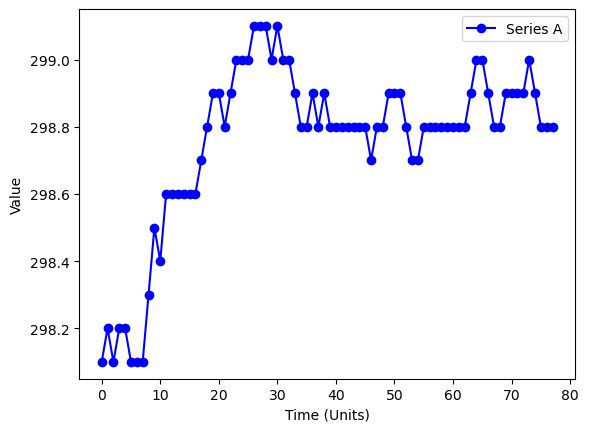

In [25]:
cobacobay = df.iloc[0:78]["Air temperature [K]"]
cobacobax = list(cobacobay.index)

plt.plot(cobacobax, cobacobay, color='blue', linestyle='-', marker='o', label='Series A')

# Adding labels and title
plt.xlabel("Time (Units)")
plt.ylabel("Value")

# Adding a legend
plt.legend()

# Displaying the plot
plt.show()

/tmp/ipykernel_65804/361346509.py:15: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


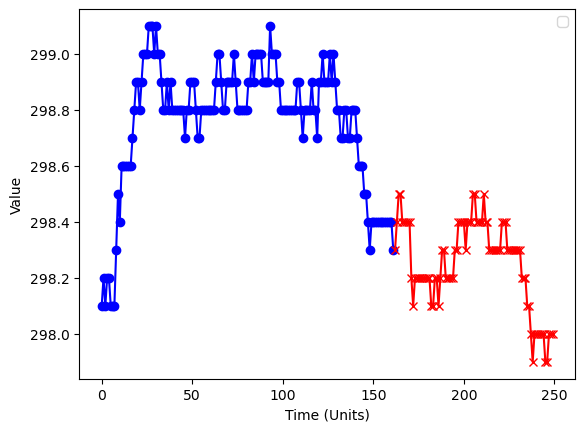

In [34]:
cobacoba = df.iloc[0:162]["Air temperature [K]"]
cobacobax = list(cobacoba.index)

cobacoba2 = df.iloc[162:250]["Air temperature [K]"]
cobacobax2 = list(cobacoba2.index)

plt.plot(cobacobax, cobacoba, color='blue', linestyle='-', marker='o')
plt.plot(cobacobax2, cobacoba2, color='red', linestyle='-', marker='x')

# Adding labels and title
plt.xlabel("Time (Units)")
plt.ylabel("Value")

# Adding a legend
plt.legend()

# Displaying the plot
plt.show()

In [ ]:
# with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
#     display(df[162:])

In [4]:
# Shuffle the dataset
df = df.sample(frac=1).reset_index(drop=True)
df.head()

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type
0,9862,M24721,M,298.7,309.6,1800,24.8,78,0,No Failure
1,3132,L50311,L,300.1,309.5,1660,32.7,57,0,No Failure
2,3616,M18475,M,301.8,311.1,1647,31.6,6,0,No Failure
3,5094,M19953,M,304.0,313.3,1415,52.8,82,0,No Failure
4,6038,L53217,L,300.7,311.1,1426,46.2,97,0,No Failure


# EDA & Preprocessing

In [5]:
print(f"Number of rows: {df.shape[0]}")
print(f"Number of columns: {df.shape[1]}")

Number of rows: 10000
Number of columns: 10


In [6]:
# dataset information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      10000 non-null  int64  
 1   Product ID               10000 non-null  object 
 2   Type                     10000 non-null  object 
 3   Air temperature [K]      10000 non-null  float64
 4   Process temperature [K]  10000 non-null  float64
 5   Rotational speed [rpm]   10000 non-null  int64  
 6   Torque [Nm]              10000 non-null  float64
 7   Tool wear [min]          10000 non-null  int64  
 8   Target                   10000 non-null  int64  
 9   Failure Type             10000 non-null  object 
dtypes: float64(3), int64(4), object(3)
memory usage: 781.4+ KB


In [7]:
df["UDI"].value_counts()

UDI
7007    1
9862    1
3132    1
3616    1
5094    1
       ..
1542    1
1780    1
4041    1
1604    1
9490    1
Name: count, Length: 10000, dtype: int64

In [8]:
# Hapus kolom UDI, karena hanya sebagai ID
df = df.drop(['UDI'], axis=1)
df = df.reset_index(drop=True)
df.columns

Index(['Product ID', 'Type', 'Air temperature [K]', 'Process temperature [K]',
       'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]', 'Target',
       'Failure Type'],
      dtype='object')

In [9]:
df["Product ID"].value_counts()

Product ID
H36420    1
M24721    1
L50311    1
M18475    1
M19953    1
         ..
L48721    1
M16639    1
L51220    1
M16463    1
L56669    1
Name: count, Length: 10000, dtype: int64

In [10]:
# Hapus kolom Product ID, karena hanya sebagai ID
df = df.drop(['Product ID'], axis=1)
df = df.reset_index(drop=True)
df.columns

Index(['Type', 'Air temperature [K]', 'Process temperature [K]',
       'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]', 'Target',
       'Failure Type'],
      dtype='object')

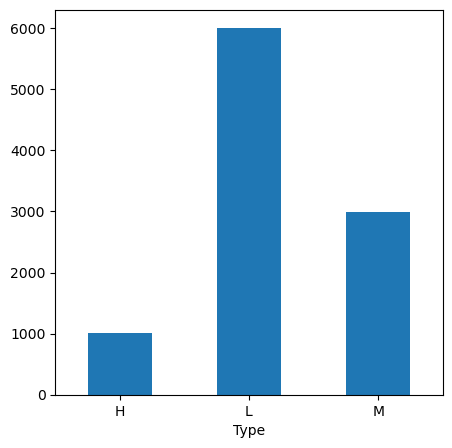

In [11]:
ax = df["Type"].value_counts().sort_index() \
    .plot(kind='bar',
          figsize=(5, 5))
ax.set_xlabel('Type')
plt.xticks(rotation=0)
plt.show()

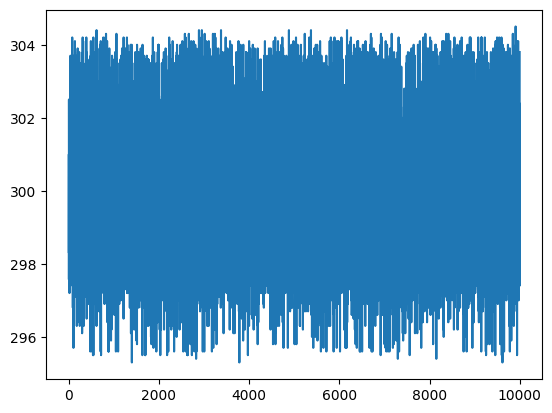

In [28]:
plt.plot(df["Air temperature [K]"])
plt.show()

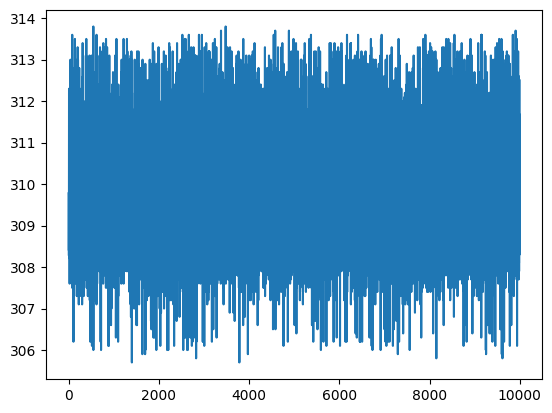

In [29]:
plt.plot(df["Process temperature [K]"])
plt.show()

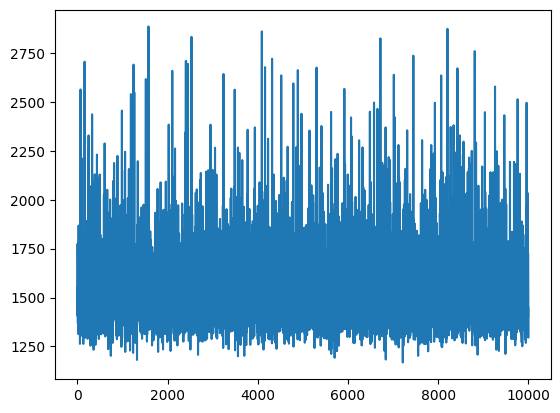

In [31]:
plt.plot(df["Rotational speed [rpm]"])
plt.show()

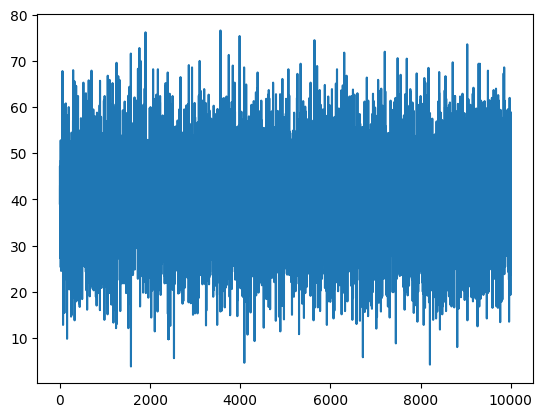

In [32]:
plt.plot(df["Torque [Nm]"])
plt.show()

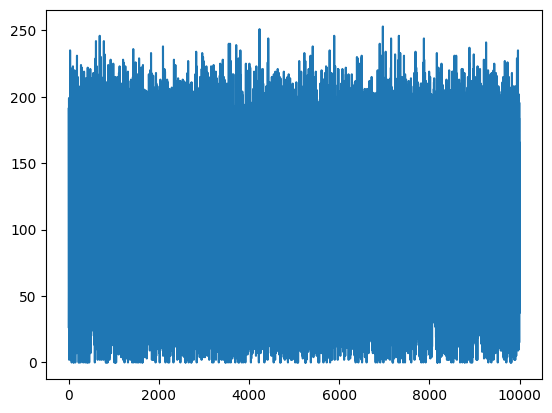

In [33]:
plt.plot(df["Tool wear [min]"])
plt.show()

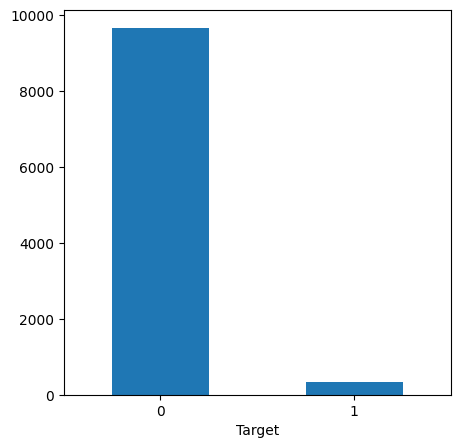

In [35]:
ax = df["Target"].value_counts().sort_index() \
    .plot(kind='bar',
          figsize=(5, 5))
ax.set_xlabel('Target')
plt.xticks(rotation=0)
plt.show()

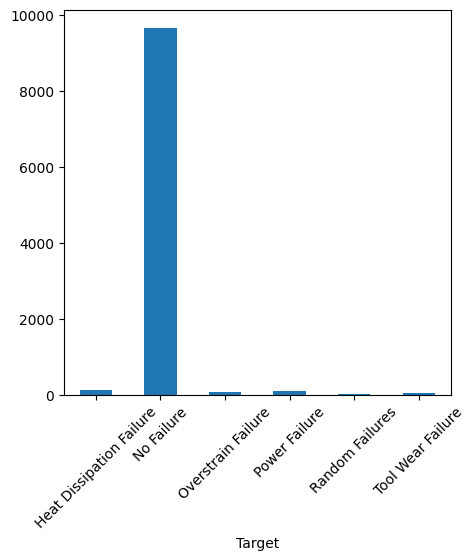

In [42]:
ax = df["Failure Type"].value_counts().sort_index() \
    .plot(kind='bar',
          figsize=(5, 5))
ax.set_xlabel('Target')
plt.xticks(rotation=45)
plt.show()

In [43]:
# Drop duplicated rows
print("Number of duplicated rows:", df.shape[0] - df.drop_duplicates().shape[0])
df = df.drop_duplicates()
df = df.reset_index(drop=True)
print()
print("Removing duplicates...")
print()
print("Number of duplicated rows:", df.shape[0] - df.drop_duplicates().shape[0])

Number of duplicated rows: 0

Removing duplicates...

Number of duplicated rows: 0
